In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Activation, Add,DepthwiseConv2D, BatchNormalization, Concatenate, Conv2D, Dense,Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Lambda,LeakyReLU, MaxPooling2D, Multiply, Permute, Reshape, UpSampling2D
import collections
import tensorflow as tf
from tensorflow.keras import regularizers
from  tensorflow.keras.initializers import *
# from keras_flops import get_flops

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = '/content/drive/MyDrive/project_six/Training'
val_path = '/content/drive/MyDrive/project_six/Validation'
test_path = '/content/drive/MyDrive/project_six/Test'
batch_size = 4
img_height = 224
img_width = 224
no_of_classes = 5
classes_name = [0,1,2,3,4]
input_shape = (img_height , img_width , 3)


random_seed = np.random.seed(1142)

datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    horizontal_flip = False,
    vertical_flip = False,
    #validation_split = 0.1,
    featurewise_std_normalization=True)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')


print(train_generator.class_indices)

Found 3432 images belonging to 5 classes.
Found 503 images belonging to 5 classes.
{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3, 'grade4': 4}


In [4]:
def se_block(block_input, num_filters, ratio=8):

	pool1 = tf.keras.layers.GlobalAveragePooling2D()(block_input)
	flat = tf.keras.layers.Reshape((1, 1, num_filters))(pool1)
	dense1 = tf.keras.layers.Dense(num_filters//ratio, activation='relu')(flat)
	dense2 = tf.keras.layers.Dense(num_filters, activation='sigmoid')(dense1)
	scale = tf.keras.layers.multiply([block_input, dense2])

	return scale


def resnet_block(block_input, num_filters):

	if tf.keras.backend.int_shape(block_input)[3] != num_filters:
		block_input = tf.keras.layers.Conv2D(num_filters, kernel_size=(1, 1))(block_input)

	conv1 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same')(block_input)
	norm1 = tf.keras.layers.BatchNormalization()(conv1)
	relu1 = tf.keras.layers.Activation('relu')(norm1)
	conv2 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same')(relu1)
	norm2 = tf.keras.layers.BatchNormalization()(conv2)

	se = se_block(norm2, num_filters=num_filters)

	sum = tf.keras.layers.Add()([block_input, se])
	relu2 = tf.keras.layers.Activation('relu')(sum)

	return relu2

def se_resnet14():

  input = tf.keras.layers.Input(shape=(224, 224, 3))
  conv1 = tf.keras.layers.Conv2D(16, kernel_size=(7, 7), activation='relu', padding='same', kernel_initializer='he_normal')(input)

  block1 = resnet_block(conv1, 16)
  block2 = resnet_block(block1, 16)
  block3 = resnet_block(block2,16)

  pool1 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block3)

  block4 = resnet_block(pool1, 32)
  block5 = resnet_block(block4, 32)
  block6 = resnet_block(block5,32)

  pool2 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block6)

  block7 = resnet_block(pool2, 64)
  block8 = resnet_block(block7, 64)
  block9 = resnet_block(block8,64)

  global_pool = tf.keras.layers.GlobalAveragePooling2D()(block9)

  output = tf.keras.layers.Dense(5, activation='softmax')(global_pool)

  model = tf.keras.models.Model(inputs=input, outputs=output)
  return model


In [5]:

# adam = tf.keras.optimizers.Adam(lr = 0.0001)
model_se = se_resnet14()
model_se.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
model_se.summary()
# flops = get_flops(model_se,batch_size=1)
# print(f"Flops:{flops/10**9:.03}G")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         2368      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 16)         64        ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
                                                  factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=40, verbose=1,
                                              mode = 'max', restore_best_weights = True)
# check_path = 'E:/Grading_Files/comp/new_work_BHC_222.h5'
check_path = '/content/drive/MyDrive/project_six/new_work_BHC_22222222.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


history = model_se.fit_generator(train_generator , validation_data = validation_generator ,
                                  steps_per_epoch= len(train_generator) ,
                                  validation_steps = len(validation_generator)
                                  ,epochs = 65,callbacks = [reduce_lr, early_stop, checkpoint] )
# model_prop.load_weights('/content/drive/MyDrive/Major_project_data/Kidney_KMC/KMC_kidney_40x_dataset/Metrics/checkpoint_anirudh_7.h5')

Epoch 1/65


<ipython-input-7-8929af0f1317>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_se.fit_generator(train_generator , validation_data = validation_generator ,


858/858 [==============================] - ETA: 0s - loss: 1.2383 - acc: 0.4726
Epoch 1: val_acc improved from -inf to 0.31412, saving model to /content/drive/MyDrive/project_six/new_work_BHC_22222222.h5
858/858 [==============================] - 807s 941ms/step - loss: 1.2383 - acc: 0.4726 - val_loss: 6.4138 - val_acc: 0.3141 - lr: 0.0010
Epoch 2/65
858/858 [==============================] - ETA: 0s - loss: 0.9358 - acc: 0.6090
Epoch 2: val_acc improved from 0.31412 to 0.48509, saving model to /content/drive/MyDrive/project_six/new_work_BHC_22222222.h5
858/858 [==============================] - 65s 76ms/step - loss: 0.9358 - acc: 0.6090 - val_loss: 1.5669 - val_acc: 0.4851 - lr: 0.0010
Epoch 3/65
858/858 [==============================] - ETA: 0s - loss: 0.8022 - acc: 0.6839
Epoch 3: val_acc improved from 0.48509 to 0.49304, saving model to /content/drive/MyDrive/project_six/new_work_BHC_22222222.h5
858/858 [==============================] - 66s 76ms/step - loss: 0.8022 - acc: 0.6839 

In [ ]:
model_se.load_weights('/content/drive/MyDrive/Paper/Weight/BHC/BHC.h5')

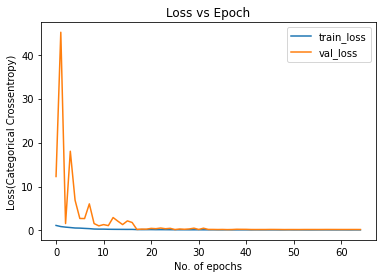

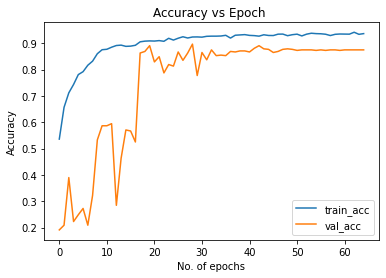

In [ ]:
import matplotlib.pyplot as plt
plt.plot(a['loss'] , label = 'train_loss')
plt.plot(a['val_loss'] , label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss(Categorical Crossentropy)")
plt.title("Loss vs Epoch")
# plt.savefig('E:/Grading_Files/comp/plot/graph/91.69-Loss.png',bbox_inches='tight')
plt.show()
plt.plot(a['acc'] , label = 'train_acc')
plt.plot(a['val_acc'] , label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch ")
# plt.savefig('E:/Grading_Files/comp/plot/graph/91.69-ACC.png',bbox_inches='tight')
plt.show()

In [ ]:
test_d = ImageDataGenerator(rescale=1. / 255)
test = test_d.flow_from_directory(
    '/content/drive/MyDrive/Paper/KMC Dataset for grading/Test',
    target_size=(224,224),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

Found 142 images belonging to 5 classes.


In [ ]:
import numpy as np
test_step = test.n//test.batch_size
test.reset()
pred = model_se.predict_generator(test , steps = test_step , verbose = 1)
pred_class_indices = np.argmax(pred,axis=1)

## printing predicted labels
print(pred_class_indices)

<ipython-input-8-0160d172a31d>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model_se.predict_generator(test , steps = test_step , verbose = 1)


142/142 [==============================] - 39s 264ms/step
[0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 4 0
 4 0 4 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 2 0 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 2 2 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3
 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4]


In [ ]:
from sklearn.metrics import *
classes = [0,1,2,3,4]


for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_______________________________")

class:  0
Accuracy 0.9507042253521126
F1 0.9090909090909091
precision 0.9722222222222222
recall 0.8536585365853658
jaccard 0.8333333333333334
_______________________________
class:  1
Accuracy 0.9788732394366197
F1 0.9411764705882353
precision 1.0
recall 0.8888888888888888
jaccard 0.8888888888888888
_______________________________
class:  2
Accuracy 0.9225352112676056
F1 0.7924528301886793
precision 0.75
recall 0.84
jaccard 0.65625
_______________________________
class:  3
Accuracy 0.9436619718309859
F1 0.8095238095238095
precision 0.8095238095238095
recall 0.8095238095238095
jaccard 0.68
_______________________________
class:  4
Accuracy 0.9507042253521126
F1 0.8852459016393442
precision 0.8181818181818182
recall 0.9642857142857143
jaccard 0.7941176470588235
_______________________________


In [ ]:
print('Accuracy {}'.format(accuracy_score(y_true=test.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('precision {}'.format(precision_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('recall {}'.format(recall_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)))
print('classification_report\n {}'.format(classification_report(y_true=test.labels, y_pred=pred_class_indices)))
print('\n\n')

Accuracy 0.8732394366197183
F1 0.8674979842061953
precision 0.86998556998557
recall 0.8712713898567557
jaccard 0.7705179738562091
confusion_matrix
 [[35  0  3  0  3]
 [ 1 24  1  0  1]
 [ 0  0 21  4  0]
 [ 0  0  2 17  2]
 [ 0  0  1  0 27]]
classification_report
               precision    recall  f1-score   support

           0       0.97      0.85      0.91        41
           1       1.00      0.89      0.94        27
           2       0.75      0.84      0.79        25
           3       0.81      0.81      0.81        21
           4       0.82      0.96      0.89        28

    accuracy                           0.87       142
   macro avg       0.87      0.87      0.87       142
weighted avg       0.88      0.87      0.88       142




